# Machine Learning Final Project

In [1]:
import pandas as pd  
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from scipy.special import gammaln
from scipy.special import psi
from scipy.special import factorial
from scipy.optimize import fmin_l_bfgs_b as optim
import sys
import random
from pyclustering.cluster.kmedoids import kmedoids
import seaborn as sns
from fit_nbinom import fit_nbinom

## 1. Data Preparation and preprocessing

winsorization...
selecting most variable genes...


/Users/shengjian/py_36_env/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


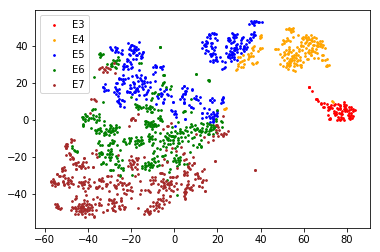

In [2]:
# Data preparation.
embryonic_data_490genes = pd.read_csv('./embryonic_data_490genes.txt', sep='\t', index_col=0)
name = embryonic_data_490genes.index
embryonic_data_490genes.columns = range(embryonic_data_490genes.shape[1])
embryonic_data_490genes.index = range(embryonic_data_490genes.shape[0])
label = pd.read_csv('./labels.txt', header = None)
embryonic_data_490genes = embryonic_data_490genes.T
embryonic_data_490genes.shape
embryonic_data_490genes = np.array(embryonic_data_490genes)
label = np.array(label)
label = np.reshape(label, (1529,))
rpkm = pd.read_csv('./rpkm.txt', sep='\t', index_col=0)

#winsorization
print("winsorization...")
embryonic_data_490genes_win = embryonic_data_490genes
length = embryonic_data_490genes.shape[0]
for i in range(embryonic_data_490genes.shape[1]):
    sort = sorted(range(length), key=lambda k: embryonic_data_490genes_win[:, i][k])
    embryonic_data_490genes_win[:, i][sort[-1]] = embryonic_data_490genes_win[:, i][sort[-2]]

#select most variable genes
print("selecting most variable genes...")
r = []
for i in range(embryonic_data_490genes_win.shape[1]):
    r.append(fit_nbinom(embryonic_data_490genes_win[:,i])['size'])
r = np.array(r)
m = np.mean(embryonic_data_490genes_win, axis = 0)
cv2 = 1/m + 1/r
embryonic_data_490genes = embryonic_data_490genes[:,cv2 < 20]

# Data preprocessing
embryonic_data_490genes_log = np.log10(1+embryonic_data_490genes)

# PCA
pca = PCA(n_components=100, random_state = 2)
X_r = pca.fit_transform(embryonic_data_490genes_log)

# TSNE
print("doing t-SNE...")
X_embedded = TSNE(n_components=2, method = 'exact', random_state=64).fit_transform(X_r)

# Plot
lab = ['E3', 'E4', 'E5', 'E6', 'E7']
color = ['red', 'orange', 'blue', 'green', 'brown']
fig, ax = plt.subplots()
for i in range(5):
    plt.scatter(X_embedded[label==i+3, 0], X_embedded[label==i+3, 1], color = color[i], label=lab[i], s = 3)
ax.legend()

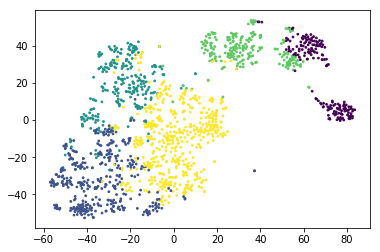

In [3]:
#directly do 5 clustering on the whole dataset
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_r)
y_pred = kmeans.predict(X_r)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y_pred, s = 3)

## 2. Calculate Markers

In [4]:
ICM_marker = ['PDGFRA', 'GDF3', 'PRDM14', 'TDGF1', 'HNF1B', 'SOX2', 'LAMA4', 'NODAL', 'DPPA5', 'IFITM1']
TE_marker = ['CLDN10', 'CLDN4', 'KRT19', 'SLC34A2', 'DAB2', 'AMOTL2', 'PTGES', 'GATA2', 'GATA3', 'PDGFA']
EPI_marker = ['PRDM1', 'DPPA5', 'SOX2', 'TDGF1', 'KLF17', 'ARGFX', 'NODAL', 'IFITM1', 'GDF3', 'PRICKLE1']
PE_marker = ['SERPINH1', 'LAMA4', 'LBH', 'BMP2', 'KIT', 'FGFR2', 'HNF1B', 'PDGFRA']

In [5]:
#gene expression 
ICM_rpkm_all = np.log10(1 + np.array(rpkm.loc[ICM_marker]))
TE_rpkm_all = np.log10(1 + np.array(rpkm.loc[TE_marker]))
ICM_sum_all = np.sum(ICM_rpkm_all, axis = 0) / len(ICM_marker)
TE_sum_all = np.sum(TE_rpkm_all, axis = 0) / len(TE_marker)
total_c_all = TE_sum_all - ICM_sum_all

EPI_rpkm_all = np.log10(1 + np.array(rpkm.loc[EPI_marker]))
PE_rpkm_all = np.log10(1 + np.array(rpkm.loc[PE_marker]))
EPI_sum_all = np.sum(EPI_rpkm_all, axis = 0) / len(EPI_marker)
PE_sum_all = np.sum(PE_rpkm_all, axis = 0) / len(PE_marker)
total_c_all_ICM = PE_sum_all - EPI_sum_all

Text(0, 0.5, 'PC2')

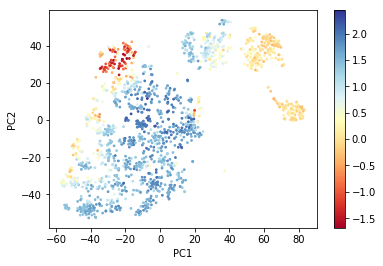

In [6]:
# Plot TE-ICM Markers on all cells.
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = total_c_all,cmap=cm,s = 3)
plt.colorbar(sc)
plt.xlabel("PC1")
plt.ylabel("PC2")

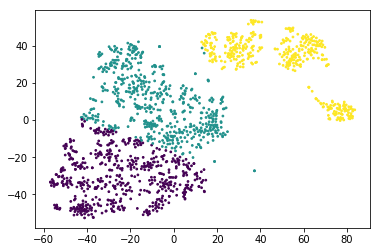

In [7]:
#directly do 3 clustering on the whole dataset
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_embedded)
y_pred = kmeans.predict(X_embedded)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y_pred, s = 3)

In [8]:
#manually find the index of pre-lineage cluster
index = 2

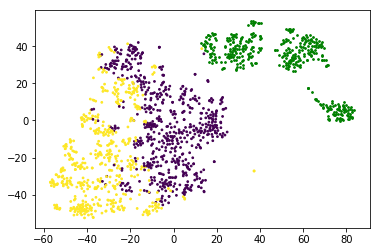

In [9]:
#extract non-pre-lineage cells
non_pre_gene = embryonic_data_490genes_log[(y_pred > index) + (y_pred < index)]
X_embedded_non_pre = X_embedded[(y_pred > index) + (y_pred < index)]
X_embedded_pre = X_embedded[y_pred==index]

pca_non_pre = PCA(n_components=100, random_state = 2)
X_r_non_pre = pca_non_pre.fit_transform(non_pre_gene)

#clustering on non-pre-lineage PCA subspace
kmeans_non_pre = KMeans(n_clusters=2, random_state=7).fit(X_r_non_pre)
y_pred_non_pre = kmeans_non_pre.predict(X_r_non_pre)
plt.scatter(X_embedded_non_pre[:, 0], X_embedded_non_pre[:, 1], c = y_pred_non_pre, s = 3)
plt.scatter(X_embedded_pre[:, 0], X_embedded_pre[:, 1], color = 'green', s = 3)

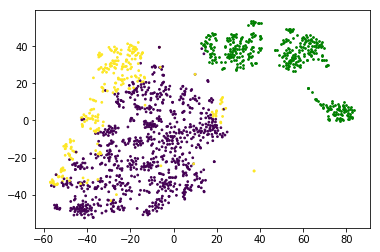

In [10]:
#extract 20 marker genes to do PCA and clustering
ICM_rpkm_all_non_lin = ICM_rpkm_all[:, (y_pred > index) + (y_pred < index)]
TE_rpkm_all_non_lin = TE_rpkm_all[:, (y_pred > index) + (y_pred < index)]
ICM_TE_rpkm_all_non_lin = np.concatenate((ICM_rpkm_all_non_lin, TE_rpkm_all_non_lin))
ICM_TE_rpkm_all_non_lin = ICM_TE_rpkm_all_non_lin.T

#PCA
pca_ICM_TE = PCA(n_components=3, random_state = 2)
X_r_ICM_TE = pca_ICM_TE.fit_transform(ICM_TE_rpkm_all_non_lin)

#k-means
kmeans_ICM_TE = KMeans(n_clusters=2, random_state=7).fit(X_r_ICM_TE)
y_pred_ICM_TE = kmeans_ICM_TE.predict(X_r_ICM_TE)

#visualization
kmeans_non_pre = KMeans(n_clusters=2, random_state=7).fit(X_r_non_pre)
y_pred_non_pre = kmeans_non_pre.predict(X_r_non_pre)
plt.scatter(X_embedded_non_pre[:, 0], X_embedded_non_pre[:, 1], c = y_pred_ICM_TE, s = 3)
plt.scatter(X_embedded_pre[:, 0], X_embedded_pre[:, 1], color = 'green', s = 3)

## 3. Clustering/Dividing E5 Cells into Lineages

### 3.1 Find the Pre-lineage cells

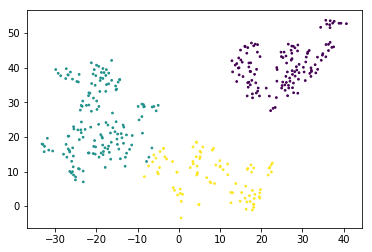

In [11]:
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import MiniBatchKMeans

lineage_true = np.zeros((X_r[label==5, :].shape[0], ))

#since we can not fit the psudo time, just use clustering to separate pre-lineage in E5
genesE5 = X_embedded[label==5, :]
kmeans_E5 = KMeans(n_clusters=3, n_init=20, random_state=32).fit(genesE5)
y_pred_E5 = kmeans_E5.predict(genesE5)

# initial_medoids = [1, 10]
# kmedoids_instance = kmedoids(genesE5, initial_medoids)
# kmedoids_instance.process()
# y_pred_E5 = kmedoids_instance.get_clusters()
# print(y_pred_E5)

plt.scatter(X_embedded[label==5, 0], X_embedded[label==5, 1], c = y_pred_E5, s = 3)
# genesE5print = X_embedded[label==5, :]
# plt.scatter(genesE5print[y_pred_E5==0, 0], genesE5print[y_pred_E5==0, 1], s = 3)
#have to manually figure which cluster is pre-lineage...now it is 1

In [12]:
#manually find the index of pre-lineage cluster in E5
pre_index = 0

In [13]:
geneE5_raw = embryonic_data_490genes_log[label == 5]
geneE5_raw_lin = geneE5_raw[(y_pred_E5 > pre_index) + (y_pred_E5 < pre_index), :]
pca_5 = PCA(n_components=200, random_state = 0)
# pca_5.fit_transform(geneE5_raw_lin)
X_r_5 = pca_5.fit_transform(geneE5_raw_lin)
geneE5_raw_pre = geneE5_raw[y_pred_E5 == pre_index, :]
X_r_5_pre = pca_5.transform(geneE5_raw_pre)

lineage_true[(y_pred_E5 > pre_index) + (y_pred_E5 < pre_index)] = np.ones((geneE5_raw_lin.shape[0],))
# display(lineage_true)  # Currently if lineage_true==1 means not pre, otherwise means pre.

### 3.2 Find the TE and ICM

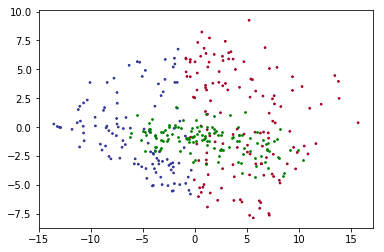

In [14]:
kmeans_E5_non_pre = KMeans(n_clusters=2, n_init=20, random_state=32).fit(X_r_5)
y_pred_E5_non_pre = kmeans_E5_non_pre.predict(X_r_5)

plt.scatter(X_r_5[:, 0], X_r_5[:, 1], c = y_pred_E5_non_pre, cmap=cm, s = 3)
plt.scatter(X_r_5_pre[:, 0], X_r_5_pre[:, 1], color = 'green', s = 3)

In [15]:
total_c_E5 = total_c_all[label==5]
total_c_E5_lin = total_c_E5[(y_pred_E5 > pre_index) + (y_pred_E5 < pre_index)]

Text(0, 0.5, 'PC2')

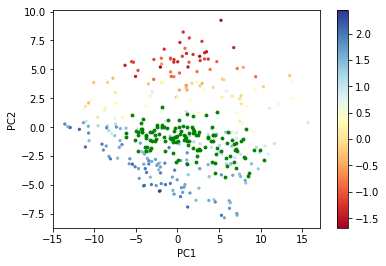

In [16]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(X_r_5[:, 0], X_r_5[:, 1], c = total_c_E5_lin,cmap=cm,s = 5)
plt.scatter(X_r_5_pre[:, 0], X_r_5_pre[:, 1], color = 'green', s = 8)
plt.colorbar(sc)
plt.xlabel("PC1")
plt.ylabel("PC2")

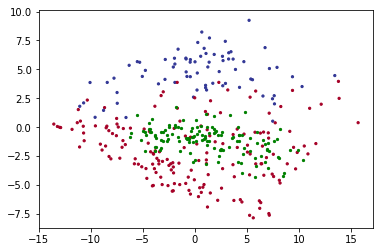

In [17]:
#rpkm of non-pre-lineage E5 cells
ICM_rpkm_E5_lin = ICM_rpkm_all[:, label==5][:, (y_pred_E5 > pre_index) + (y_pred_E5 < pre_index)]
TE_rpkm_E5_lin = TE_rpkm_all[:, label==5][:, (y_pred_E5 > pre_index) + (y_pred_E5 < pre_index)]
ICM_TE_rpkm_E5_lin = np.concatenate((ICM_rpkm_E5_lin, TE_rpkm_E5_lin))
ICM_TE_rpkm_E5_lin = ICM_TE_rpkm_E5_lin.T

#PCA
pca_E5_ICM_TE = PCA(n_components=5, random_state = 1)
pca_E5_ICM_TE.fit(ICM_TE_rpkm_E5_lin)
X_r_5_ICM_TE = pca_E5_ICM_TE.transform(ICM_TE_rpkm_E5_lin)

#k-means and visualization
kmeans_E5_ICM_TE = KMeans(n_clusters=2, random_state=0).fit(X_r_5_ICM_TE)
y_pred_E5_ICM_TE = kmeans_E5_ICM_TE.predict(X_r_5_ICM_TE)
sc = plt.scatter(X_r_5[:, 0], X_r_5[:, 1], c = y_pred_E5_ICM_TE, cmap=cm, s = 5)
plt.scatter(X_r_5_pre[:, 0], X_r_5_pre[:, 1], color = 'green', s = 5)

In [18]:

threshold = 0

geneE5_raw_ICM = geneE5_raw_lin[total_c_E5_lin<threshold]

tmp = np.ones((geneE5_raw_lin.shape[0], ))
tmp[total_c_E5_lin<threshold] = np.ones((geneE5_raw_ICM.shape[0], )) * 2

print(tmp)

try: 
    lineage_true[lineage_true > 0] = tmp
except:
    print("ERROR: Please run the former cells, at least rerun from the start of Part 3!")

#get ICM cell from the E5 lineage cell
# geneE5_raw_ICM = geneE5_raw_lin[total_c_E5_lin<-2]

geneE5_raw_ICM.shape

[1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2. 2. 1.
 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 1. 2. 2. 2. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 1. 2. 2. 1. 1. 2. 2. 1. 1. 2. 2. 2. 2. 1. 1. 2. 2. 1. 2. 1.
 1. 1. 1. 2. 2. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 1.
 2. 1. 1. 2. 2. 2. 2. 1. 2. 2. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 2. 1.
 1. 1. 1. 2. 2.]


(65, 248)

In [19]:
# lineage_true

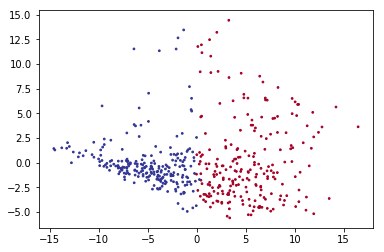

In [20]:
#similar operation on E7 data
geneE7_raw = embryonic_data_490genes_log[label == 7]
pca_7 = PCA(n_components=100, random_state = 0)
# pca_5.fit_transform(geneE5_raw_lin)
X_r_7 = pca_7.fit_transform(geneE7_raw)

kmeans_E7 = KMeans(n_clusters=2, n_init=20, random_state=32).fit(X_r_7)
y_pred_E7 = kmeans_E7.predict(X_r_7)

plt.scatter(X_r_7[:, 0], X_r_7[:, 1], c = y_pred_E7, cmap=cm, s = 3)

Text(0, 0.5, 'PC2')

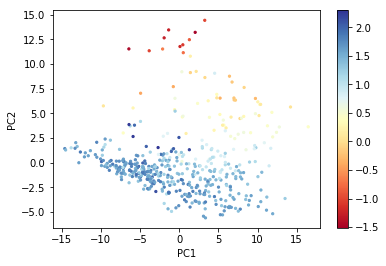

In [21]:
total_c_E7 = total_c_all[label==7]

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(X_r_7[:, 0], X_r_7[:, 1], c = total_c_E7,cmap=cm,s = 5)
plt.colorbar(sc)
plt.xlabel("PC1")
plt.ylabel("PC2")

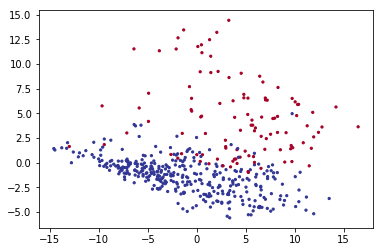

In [22]:
#rpkm of E7 cells
ICM_rpkm_E7 = ICM_rpkm_all[:, label==7]
TE_rpkm_E7 = TE_rpkm_all[:, label==7]
ICM_TE_rpkm_E7 = np.concatenate((ICM_rpkm_E7, TE_rpkm_E7))
ICM_TE_rpkm_E7 = ICM_TE_rpkm_E7.T

#PCA
pca_E7_ICM_TE = PCA(n_components=5, random_state = 1)
pca_E7_ICM_TE.fit(ICM_TE_rpkm_E7)
X_r_7_ICM_TE = pca_E7_ICM_TE.transform(ICM_TE_rpkm_E7)

#k-means and visualization
kmeans_E7_ICM_TE = KMeans(n_clusters=2, random_state=0).fit(X_r_7_ICM_TE)
y_pred_E7_ICM_TE = kmeans_E7_ICM_TE.predict(X_r_7_ICM_TE)
sc = plt.scatter(X_r_7[:, 0], X_r_7[:, 1], c = y_pred_E7_ICM_TE,cmap=cm,s = 5)

### 3.3 Find EPI and PE

Text(0, 0.5, 'PC2')

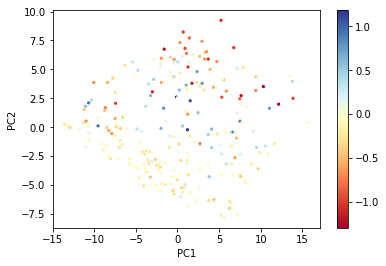

In [23]:
total_c_E5_ICM = total_c_all_ICM[label==5]
total_c_E5_lin_ICM = total_c_E5_ICM[(y_pred_E5 > pre_index) + (y_pred_E5 < pre_index)]

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(X_r_5[:, 0], X_r_5[:, 1], c = total_c_E5_lin_ICM,cmap=cm,s = 5)
plt.colorbar(sc)
plt.xlabel("PC1")
plt.ylabel("PC2")

In [24]:
pca_5_ICM = PCA(n_components=30, random_state = 0)
pca_5_ICM.fit_transform(geneE5_raw_ICM)
X_r_5_ICM = pca_5_ICM.transform(geneE5_raw_ICM)

In [25]:
total_c_E5_ICM = total_c_E5_lin_ICM[total_c_E5_lin<threshold]

In [26]:
total_c_E5_ICM.shape

(65,)

Text(0, 0.5, 'PC2')

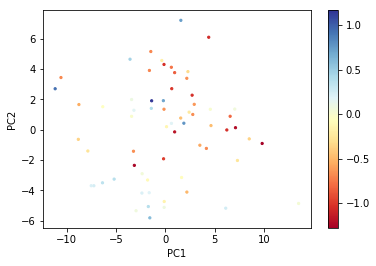

In [27]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(X_r_5_ICM[:, 0], X_r_5_ICM[:, 1], c = total_c_E5_ICM,cmap=cm,s = 5)
plt.colorbar(sc)
plt.xlabel("PC1")
plt.ylabel("PC2")

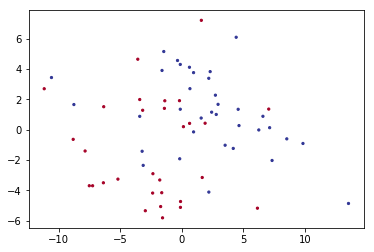

In [28]:
#rpkm of non-pre-lineage ICM E5 cells
EPI_rpkm_E5_lin = EPI_rpkm_all[:, label==5][:, (y_pred_E5 > pre_index) + (y_pred_E5 < pre_index)][:, total_c_E5_lin<threshold]
PE_rpkm_E5_lin = PE_rpkm_all[:, label==5][:, (y_pred_E5 > pre_index) + (y_pred_E5 < pre_index)][:, total_c_E5_lin<threshold]
EPI_PE_rpkm_E5 = np.concatenate((EPI_rpkm_E5_lin, PE_rpkm_E5_lin))
EPI_PE_rpkm_E5 = EPI_PE_rpkm_E5.T

#PCA
pca_E5_EPI_PE = PCA(n_components=5, random_state = 1)
pca_E5_EPI_PE.fit(EPI_PE_rpkm_E5)
X_r_5_EPI_PE = pca_E5_EPI_PE.transform(EPI_PE_rpkm_E5)

#k-means and visualization
kmeans_E5_EPI_PE = KMeans(n_clusters=2, random_state=0).fit(X_r_5_EPI_PE)
y_pred_E5_EPI_PE = kmeans_E5_EPI_PE.predict(X_r_5_EPI_PE)
sc = plt.scatter(X_r_5_ICM[:, 0], X_r_5_ICM[:, 1], c = y_pred_E5_EPI_PE,cmap=cm,s = 5)



Text(0, 0.5, 'PC2')

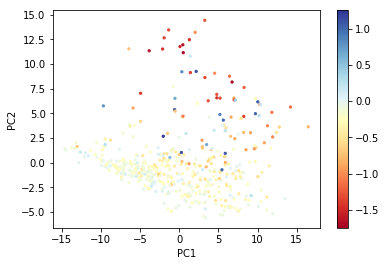

In [29]:
#separate E7 ICM data into EPI and PE
total_c_E7_ICM = total_c_all_ICM[label==7]

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(X_r_7[:, 0], X_r_7[:, 1], c = total_c_E7_ICM, cmap=cm,s = 5)
plt.colorbar(sc)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0, 0.5, 'PC2')

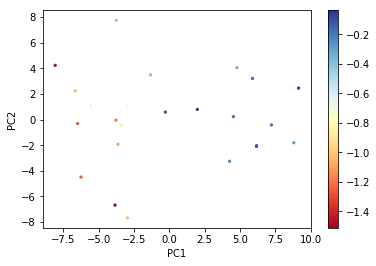

In [30]:
geneE7_raw_ICM = geneE7_raw[total_c_E7 < threshold]
total_c_E7_ICM = total_c_E7[total_c_E7 < threshold]

pca_7_ICM = PCA(n_components=10, random_state = 0)
X_r_7_ICM = pca_7_ICM.fit_transform(geneE7_raw_ICM)

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(X_r_7_ICM[:, 0], X_r_7_ICM[:, 1], c = total_c_E7_ICM,cmap=cm,s = 5)
plt.colorbar(sc)
plt.xlabel("PC1")
plt.ylabel("PC2")

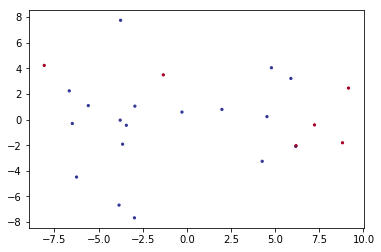

In [31]:
#rpkm of E7 cells
EPI_rpkm_E7 = EPI_rpkm_all[:, label==7][:, total_c_E7<threshold]
PE_rpkm_E7 = PE_rpkm_all[:, label==7][:, total_c_E7<threshold]
EPI_TE_rpkm_E7 = np.concatenate((EPI_rpkm_E7, PE_rpkm_E7))
EPI_TE_rpkm_E7 = EPI_TE_rpkm_E7.T

#PCA
pca_E7_EPI_TE = PCA(n_components=5, random_state = 1)
pca_E7_EPI_TE.fit(EPI_TE_rpkm_E7)
X_r_7_EPI_TE = pca_E7_EPI_TE.transform(EPI_TE_rpkm_E7)

cm = plt.cm.get_cmap('RdYlBu')
#k-means and visualization
kmeans_E7_EPI_TE = KMeans(n_clusters=2, random_state=0).fit(X_r_7_EPI_TE)
y_pred_E7_EPI_TE = kmeans_E7_EPI_TE.predict(X_r_7_EPI_TE)
sc = plt.scatter(X_r_7_ICM[:, 0], X_r_7_ICM[:, 1], c = y_pred_E7_EPI_TE,cmap=cm,s = 5)

In [33]:
threshold_ICM = -0.5

genes_E5_EPI = X_r_5_ICM[total_c_E5_ICM<threshold_ICM]

tmp_ICM = np.ones((total_c_E5_ICM.shape[0], )) * 2
tmp_ICM[total_c_E5_ICM<threshold_ICM] = np.ones((genes_E5_EPI.shape[0], )) * 3

print(tmp_ICM)

try: 
    lineage_true[lineage_true > 1] = tmp_ICM
except:
    print("ERROR: Please run the former cells, at least rerun from the start of Part 3!")

# get ICM cell from the E5 lineage cell
# geneE5_raw_ICM = geneE5_raw_lin[total_c_E5_lin<-2]

genes_E5_EPI.shape

[3. 3. 2. 2. 3. 3. 2. 2. 2. 2. 2. 3. 2. 2. 2. 2. 3. 2. 2. 3. 3. 3. 2. 3.
 3. 2. 2. 3. 3. 3. 2. 2. 2. 3. 3. 3. 2. 2. 2. 3. 3. 3. 3. 2. 2. 3. 2. 2.
 2. 3. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 3. 2. 2. 2. 2.]


(25, 30)

In [34]:
print("There are %d pre-lineage cells" % (lineage_true[lineage_true == 0].shape[0]))
print("There are %d TE cells" % (lineage_true[lineage_true == 1].shape[0]))
print("There are %d PE cells" % (lineage_true[lineage_true == 2].shape[0]))
print("There are %d EPI cells" % (lineage_true[lineage_true == 3].shape[0]))

There are 132 pre-lineage cells
There are 180 TE cells
There are 40 PE cells
There are 25 EPI cells


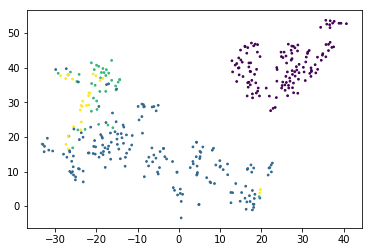

In [35]:
plt.scatter(X_embedded[label==5, 0], X_embedded[label==5, 1], c = lineage_true, s = 3)

## 4. Training the Classifier

In [36]:
import os
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import itertools 

In [37]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
    	cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    	print("Normalized confusion matrix")
    else:
    	print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    	plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [38]:
class_names = ['Pre-lineage', 'TE', 'PE', 'EPI']

### 4.1 Feature Selection

/Users/shengjian/py_36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Optimal number of features : 58


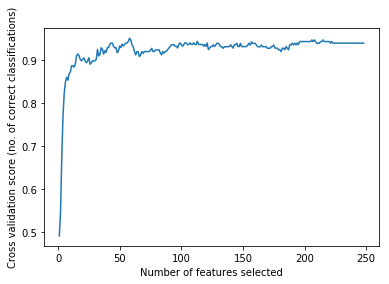

In [39]:
genesE5 = embryonic_data_490genes_log[label == 5, :]
y_true = lineage_true

from sklearn.model_selection import StratifiedKFold

X_train, X_test, Y_train, Y_test = train_test_split(genesE5, lineage_true, train_size = 0.7, random_state=0)

svc = SVC(kernel='linear', random_state=0)
rfecv = RFECV(estimator = svc, step = 1, cv = StratifiedKFold(10), scoring = 'accuracy')
rfecv.fit(X_train, Y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (no. of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### 4.2 Linear SVM

/Users/shengjian/py_36_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/shengjian/py_36_env/lib/python3.6/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (125) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 124)
  n_samples_majority))
/Users/shengjian/py_36_env/lib/python3.6/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (125) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 124)
  n_samples_majority))
/Users/shengjian/py_36_env/lib/python3.6/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (200) in class 2 will be larger than the number of samples in the majority class (class #1.0 -> 1

The average performance of ten-fold cross validation for SVM model is 0.9577
Confusion matrix, without normalization
[[37  0  0  0]
 [ 0 55  1  0]
 [ 0  0 13  1]
 [ 0  0  0  7]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        37
         1.0       1.00      0.98      0.99        56
         2.0       0.93      0.93      0.93        14
         3.0       0.88      1.00      0.93         7

   micro avg       0.98      0.98      0.98       114
   macro avg       0.95      0.98      0.96       114
weighted avg       0.98      0.98      0.98       114



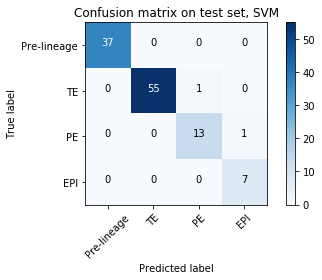

In [41]:
from imblearn.over_sampling import SMOTE

X_train, X_test, Y_train, Y_test = train_test_split(genesE5, lineage_true, train_size = 0.7, random_state=42)

X_train_rfecv = rfecv.transform(X_train) 
X_test_rfecv = rfecv.transform(X_test)
X_rfecv = rfecv.transform(genesE5)

clf_svm = SVC(kernel="linear", random_state=0)
scores_svm = cross_val_score(clf_svm, X_rfecv, lineage_true, cv=10)
print("The average performance of ten-fold cross validation for SVM model is %.4f" % (np.mean(scores_svm)))

# Train the real classifier.
# clf_svm.fit(X_train_rfecv, Y_train)
smt = SMOTE(sampling_strategy={0 : 125, 1 : 125, 2: 200, 3: 200}, random_state=42)
X_new, Y_new = smt.fit_sample(X_train_rfecv, Y_train)
clf_svm.fit(X_new, Y_new)

y_predict_svm = clf_svm.predict(X_test_rfecv)

plot_confusion_matrix(confusion_matrix(Y_test, y_predict_svm), class_names, normalize=False, title='Confusion matrix on test set, SVM', cmap=plt.cm.Blues)
print(classification_report(Y_test, y_predict_svm))

## 5. Applying the Classifier

Classification result of E3


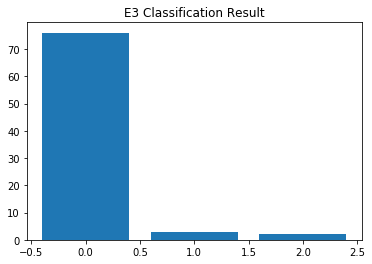

In [42]:
clf_svm.fit(X_rfecv, lineage_true)

genesE3 = embryonic_data_490genes_log[label == 3, :]
genesE3_rfecv = rfecv.transform(genesE3)
y_pred_E3 = clf_svm.predict(genesE3_rfecv)
print("Classification result of E3")
# print(y_pred_E3)
E3_frequency = Counter(y_pred_E3)
names = list(E3_frequency.keys())
frequency = list(E3_frequency.values())
plt.bar(names, frequency)
plt.title("E3 Classification Result")
plt.show()

Classification result of E4


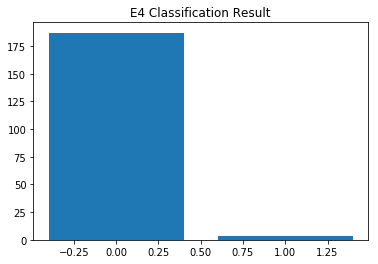

In [43]:
genesE4 = embryonic_data_490genes_log[label == 4, :]
genesE4_rfecv = rfecv.transform(genesE4)
y_pred_E4 = clf_svm.predict(genesE4_rfecv)
print("Classification result of E4")
# print(y_pred_E3)
E4_frequency = Counter(y_pred_E4)
names = list(E4_frequency.keys())
frequency = list(E4_frequency.values())
plt.bar(names, frequency)
plt.title("E4 Classification Result")
plt.show()

Classification result of E6


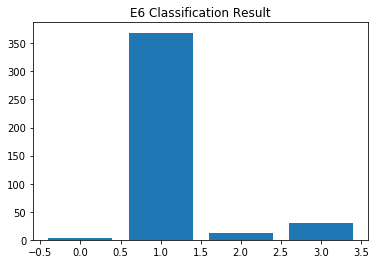

In [44]:
genesE6 = embryonic_data_490genes_log[label == 6, :]
genesE6_rfecv = rfecv.transform(genesE6)
y_pred_E6 = clf_svm.predict(genesE6_rfecv)
print("Classification result of E6")
# print(y_pred_E3)
E6_frequency = Counter(y_pred_E6)
names = list(E6_frequency.keys())
frequency = list(E6_frequency.values())
plt.bar(names, frequency)
plt.title("E6 Classification Result")
plt.show()

Classification result of E7


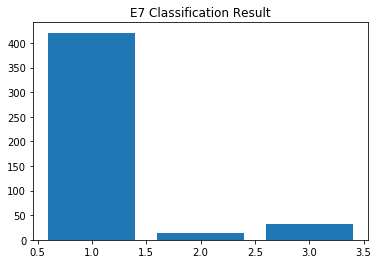

In [45]:
genesE7 = embryonic_data_490genes_log[label == 7, :]
genesE7_rfecv = rfecv.transform(genesE7)
y_pred_E7 = clf_svm.predict(genesE7_rfecv)
print("Classification result of E7")
# print(y_pred_E3)
E7_frequency = Counter(y_pred_E7)
names = list(E7_frequency.keys())
frequency = list(E7_frequency.values())
plt.bar(names, frequency)
plt.title("E7 Classification Result")
plt.show()